# Heterogeneous Autoregressive model

The HAR model assumes that the volatility (or other financial variables) is driven by components at different time scales (long-term, medium-term, and short-term).

## Import Packages and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.set_index(df.columns[0], inplace=True)
df.dropna(inplace=True)
df.head(2)

,open,high,low,close,return,return2,RV,lnRV,lnRV_lag1,lnRV_5D_lag1,lnRV_7D_lag1,lnRV_22D_lag1,lnRV_30D_lag1,lnRV_60D_lag1,lnRV_lag3,lnRV_5D_lag3,lnRV_7D_lag3,lnRV_22D_lag3,lnRV_30D_lag3,lnRV_60D_lag3
timestamp,,,,,,,,,,,,,,,,,,,,
2019-08-24,0.574,0.580,0.542,0.577,0.001735,0.000003,0.003904,-5.545689,-5.206578,-5.145997,-5.270696,-4.823593,-4.876759,-4.73776,-5.177089,-5.334462,-5.232313,-4.837572,-4.847512,-4.692676
2019-08-25,0.578,0.582,0.530,0.538,-0.069984,0.004898,0.004892,-5.320139,-5.545689,-5.177275,-5.283678,-4.940086,-4.883515,-4.77749,-5.015983,-5.246696,-5.275639,-4.806067,-4.863660,-4.711858


## Train Test Split

In [3]:
df_train = df.loc[:'2024-01-01']
df_test = df.loc['2024-01-01':]

In [4]:
date_ticks = ['2024-01-01', '2024-04-01', '2024-07-01', '2024-10-01', '2025-01-01']

## 1-day ahead forecasting

### HAR(1,5,22)

$$
lnRV_t = \alpha + \beta_1 lnRV_{t-1} + \beta_2 lnRV_{5D, t-1} + \beta_3 lnRV_{22D, t-1} + \epsilon_t
$$
Where:
- $lnRV_t$ is the dependent variable (e.g., log realised volatility of return) at time \( t \).
- $\alpha$ is a constant term.
- $\beta_1, \beta_2, \beta_3$ are the coefficients for different time lags.
- $lnRV_{5D, t-1}$ and $lnRV_{22D, t-1}$ are the 1-day lag of the average log realised volatility of return over the past 5 days and 22 days respectively.
- $\epsilon_t$ is the error term.

In [5]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag1', 'lnRV_5D_lag1', 'lnRV_22D_lag1']]
y_test = df_test['lnRV']
X_test = df_test[['lnRV_lag1', 'lnRV_5D_lag1', 'lnRV_22D_lag1']]

In [6]:
# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnRV   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1126.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:46:52   Log-Likelihood:                -1220.2
No. Observations:                1592   AIC:                             2448.
Df Residuals:                    1588   BIC:                             2470.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4374      0.106     -4.144

In [7]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
df_pred = pd.read_csv('../res/pred.csv')
df_pred['HAR(1,5,22)'] = np.exp(y_pred).values
df_pred.to_csv('../res/pred.csv', index=False)

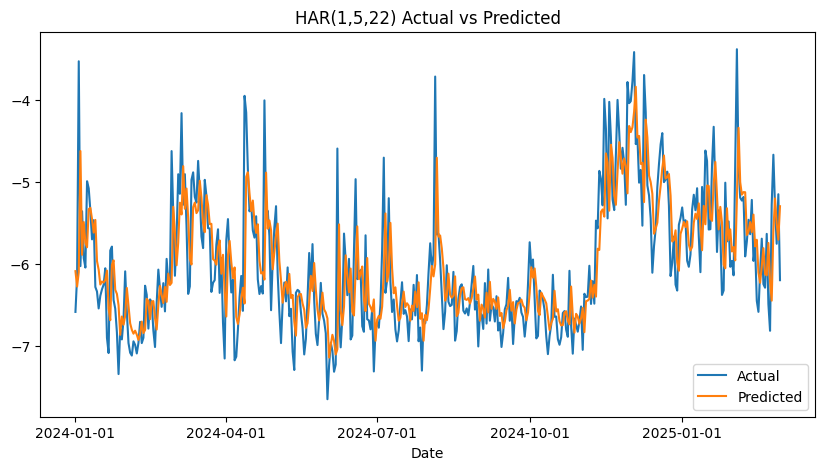

In [8]:
# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,5,22) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/HAR(1,5,22)_Actual_vs_Predicted.png')

### HAR(1,7,22)

$$
lnRV_t = \alpha + \beta_1 lnRV_{t-1} + \beta_2 lnRV_{7D, t-1} + \beta_3 lnRV_{30D, t-1} + \epsilon_t
$$
Where:
- $lnRV_t$ is the dependent variable (e.g., log realised volatility of return) at time \( t \).
- $\alpha$ is a constant term.
- $\beta_1, \beta_2, \beta_3$ are the coefficients for different time lags.
- $lnRV_{7D, t-1}$ and $lnRV_{30D, t-1}$ are the 1-day lag of the average log realised volatility of return over the past 7 days and 30 days respectively.
- $\epsilon_t$ is the error term.

In [10]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag1', 'lnRV_7D_lag1', 'lnRV_30D_lag1']]
y_test = df_test['lnRV']
X_test = df_test[['lnRV_lag1', 'lnRV_7D_lag1', 'lnRV_30D_lag1']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnRV   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     1128.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        21:47:45   Log-Likelihood:                -1219.4
No. Observations:                1592   AIC:                             2447.
Df Residuals:                    1588   BIC:                             2468.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4001      0.109     -3.675

In [11]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
df_pred = pd.read_csv('../res/pred.csv')
df_pred['HAR(1,7,30)'] = np.exp(y_pred).values
df_pred.to_csv('../res/pred.csv', index=False)

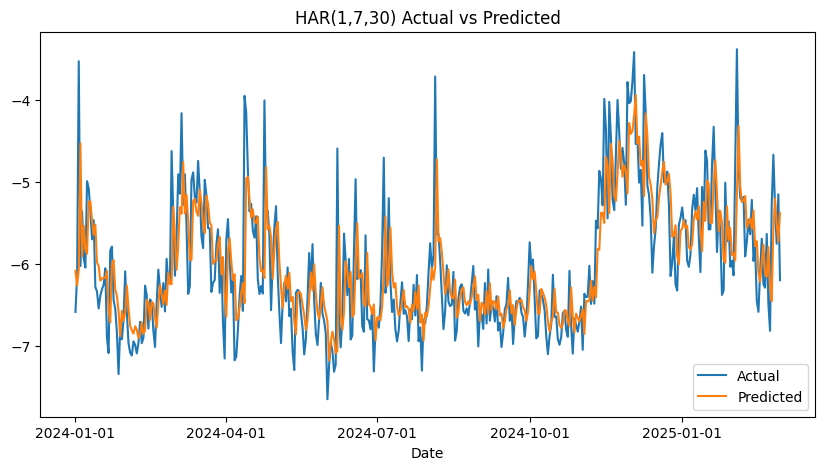

In [12]:
# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,7,30) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/HAR(1,7,30)_Actual_vs_Predicted.png')

## 3-day ahead forecasting

### HAR(1,5,22)

In [16]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag3', 'lnRV_5D_lag3', 'lnRV_22D_lag3']]
X_test = df_test[['lnRV_lag3', 'lnRV_5D_lag3', 'lnRV_22D_lag3']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnRV   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     584.1
Date:                Tue, 25 Mar 2025   Prob (F-statistic):          8.80e-256
Time:                        21:53:36   Log-Likelihood:                -1536.0
No. Observations:                1592   AIC:                             3080.
Df Residuals:                    1588   BIC:                             3102.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.8540      0.129     -6.644

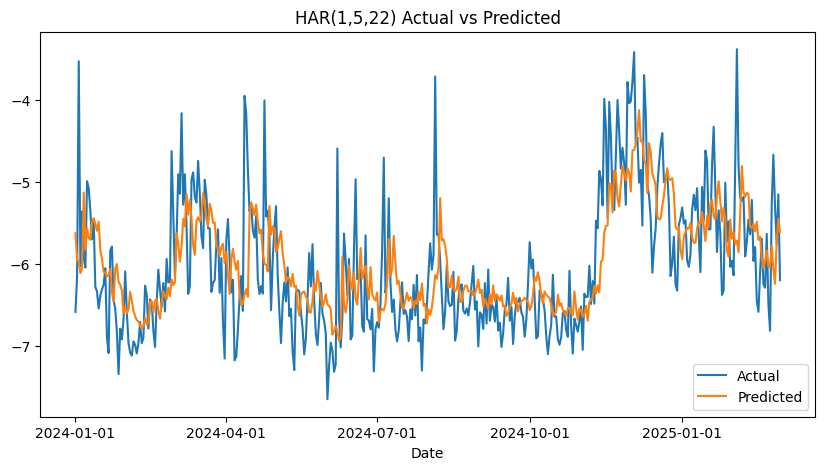

In [17]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
df_pred = pd.read_csv('../res/pred.csv')
df_pred['HAR(1,5,22)_3D'] = np.exp(y_pred).values
df_pred.to_csv('../res/pred.csv', index=False)

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,5,22) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/HAR(1,5,22)_3D-ahead-forecasting_Actual_vs_Predicted.png')

### HAR(1,7,22)

In [18]:
# Define dependent (y) and independent variables (X)
y_train = df_train['lnRV']
X_train = df_train[['lnRV_lag3', 'lnRV_7D_lag3', 'lnRV_30D_lag3']]
X_test = df_test[['lnRV_lag3', 'lnRV_7D_lag3', 'lnRV_30D_lag3']]

# Add a constant to the independent value
X_train = sm.add_constant(X_train)

# Fit the OLS regression
model = sm.OLS(y_train, X_train).fit()

# Print summary of results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnRV   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     574.5
Date:                Tue, 25 Mar 2025   Prob (F-statistic):          8.48e-253
Time:                        21:54:36   Log-Likelihood:                -1542.9
No. Observations:                1592   AIC:                             3094.
Df Residuals:                    1588   BIC:                             3115.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.7728      0.133     -5.800

In [ ]:
# Predict y values
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test)

# Save the predicted values
df_pred = pd.read_csv('../res/pred.csv')
df_pred['HAR(1,7,30)_3D'] = np.exp(y_pred).values
df_pred.to_csv('../res/pred.csv', index=False)

# Plot the predicted values against the actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("HAR(1,7,30) Actual vs Predicted")
plt.xlabel("Date")
plt.xticks(ticks=date_ticks)
plt.legend()

# Save the plot
plt.savefig('../res/HAR(1,7,30)_3D-ahead-forecasting_Actual_vs_Predicted.png')